In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from joblib import dump, load
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, F1Score
from keras.layers import Dense, Dropout
#nltk.download('punkt')

In [2]:
df = pd.read_csv('spooky_cleaned.csv')
df.head()

,id,text,author,space_tokenized_text,stemmed_text
0,id26305,process however afforded means ascertaining di...,EAP,"['process', 'however', 'afforded', 'means', 'a...",process howev afford mean ascertain dimens dun...
1,id17569,never occurred fumbling might mere mistake,HPL,"['never', 'occurred', 'fumbling', 'might', 'me...",never occur fumbl might mere mistak
2,id11008,left hand gold snuff box capered hill cutting ...,EAP,"['left', 'hand', 'gold', 'snuff', 'box', 'cape...",left hand gold snuff box caper hill cut manner...
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,"['lovely', 'spring', 'looked', 'windsor', 'ter...",love spring look windsor terrac sixteen fertil...
4,id12958,finding nothing else even gold superintendent ...,HPL,"['finding', 'nothing', 'else', 'even', 'gold',...",find noth els even gold superintend abandon at...


In [3]:
df.dropna(inplace=True)

In [4]:
X = df['stemmed_text']
y = df['author']

In [5]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Convert y to one-hot encoded format
y = to_categorical(y)

In [6]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X)

In [7]:
X_train_cv = X_train_cv.toarray()

In [8]:
import keras_tuner
import tensorflow as tf
import keras
import numpy as np

In [9]:
class MyHyperModel(keras_tuner.HyperModel):

    def build(self, hp):
        model = keras.Sequential()

        units_1 = hp.Choice('units_1', values=[8, 16, 32, 64, 128])

        model.add(Dense(
            units_1, activation='sigmoid', input_shape=X_train_cv.shape[1:]
        ))

        units_2 = hp.Choice('units_2', values=[8, 16, 32, 64, 128])

        model.add(Dense(
            units_2, activation='sigmoid'
        ))

        #model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))

        num_classes = y.shape[-1]

        model.add(Dense(num_classes, activation='softmax'))

        optimizer = Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)
        )

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args, **kwargs)

In [10]:
tuner = keras_tuner.RandomSearch(
    objective='val_accuracy',
    executions_per_trial=2,
    max_trials=100,
    hypermodel=MyHyperModel(),
    directory="results",
    project_name="tp3",
)

Reloading Tuner from results\tp3\tuner0.json


In [11]:
tuner.search(X_train_cv, y, epochs=10, validation_split=0.33)

In [12]:
# print the best parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 64, 'units_2': 32, 'learning_rate': 0.0004503919820457184}

In [13]:
#make a model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

model.compile(optimizer=Adam(best_hps.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

#train the model and capture loss and accuracy
history = model.fit(X_train_cv, y, epochs=15, validation_split=0.2)


Epoch 1/15


490/490 [==============================] - 6s 10ms/step - loss: 1.0471 - accuracy: 0.4373 - precision: 0.4578 - recall: 0.0090 - f1_score: 0.2993 - val_loss: 0.9626 - val_accuracy: 0.6080 - val_precision: 0.9877 - val_recall: 0.0409 - val_f1_score: 0.5634
Epoch 2/15
490/490 [==============================] - 5s 10ms/step - loss: 0.7895 - accuracy: 0.7363 - precision: 0.9413 - recall: 0.3607 - f1_score: 0.7268 - val_loss: 0.6550 - val_accuracy: 0.7873 - val_precision: 0.8957 - val_recall: 0.5878 - val_f1_score: 0.7852
Epoch 3/15
490/490 [==============================] - 5s 10ms/step - loss: 0.5012 - accuracy: 0.8464 - precision: 0.9099 - recall: 0.7413 - f1_score: 0.8457 - val_loss: 0.4985 - val_accuracy: 0.8172 - val_precision: 0.8639 - val_recall: 0.7469 - val_f1_score: 0.8155
Epoch 4/15
490/490 [==============================] - 5s 9ms/step - loss: 0.3583 - accuracy: 0.8830 - precision: 0.9177 - recall: 0.8379 - f1_score: 0.8830 - val_loss: 0.4471 - val_accuracy: 0.825

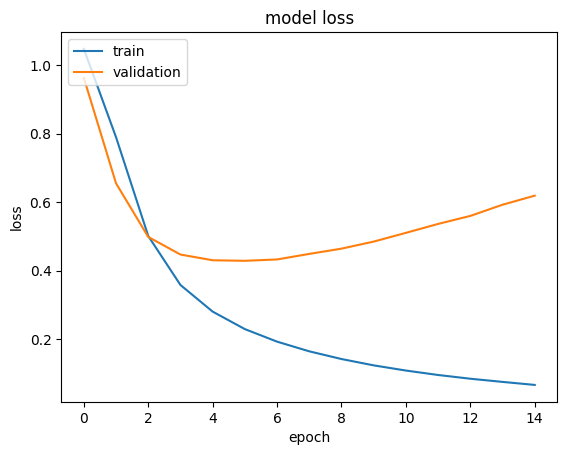

In [14]:
#plot the training loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

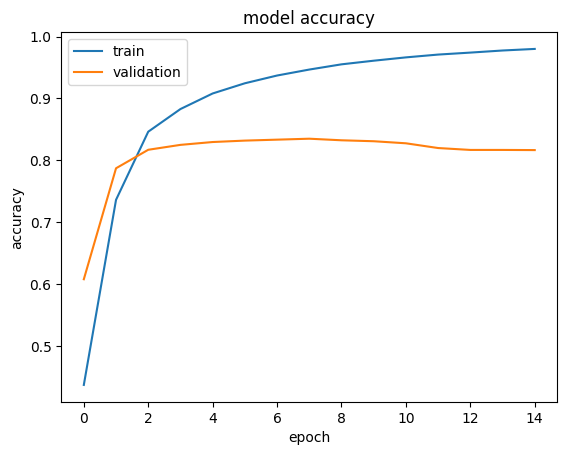

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [22]:
from keras.regularizers import l2
l2_coeff = 0.001

model = keras.Sequential([
    Dense(best_hps.values["units_1"], activation='sigmoid', input_shape=X_train_cv.shape[1:],
          kernel_regularizer=l2(l2_coeff)),
    Dense(best_hps.values["units_2"], activation='sigmoid', kernel_regularizer=l2(l2_coeff)),
    Dense(y.shape[-1], activation='softmax', kernel_regularizer=l2(l2_coeff))
])

model.compile(optimizer=Adam(best_hps.get('learning_rate')), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])

history = model.fit(X_train_cv, y, epochs=100, validation_split=0.2)


Epoch 1/100
490/490 [==============================] - 7s 11ms/step - loss: 1.1288 - accuracy: 0.4068 - precision_3: 1.0000 - recall_3: 6.3857e-05 - f1_score: 0.2206 - val_loss: 1.1164 - val_accuracy: 0.5079 - val_precision_3: 1.0000 - val_recall_3: 2.5536e-04 - val_f1_score: 0.3751
Epoch 2/100
490/490 [==============================] - 5s 10ms/step - loss: 1.1035 - accuracy: 0.4457 - precision_3: 0.9838 - recall_3: 0.0116 - f1_score: 0.2839 - val_loss: 1.0923 - val_accuracy: 0.4492 - val_precision_3: 0.9787 - val_recall_3: 0.0352 - val_f1_score: 0.2937
Epoch 3/100
490/490 [==============================] - 5s 10ms/step - loss: 1.0780 - accuracy: 0.5341 - precision_3: 0.9081 - recall_3: 0.0612 - f1_score: 0.4466 - val_loss: 1.0611 - val_accuracy: 0.6029 - val_precision_3: 0.9045 - val_recall_3: 0.0822 - val_f1_score: 0.5572
Epoch 4/100
490/490 [==============================] - 5s 9ms/step - loss: 1.0427 - accuracy: 0.6165 - precision_3: 0.8964 - recall_3: 0.1503 - f1_score: 0.5723 - v

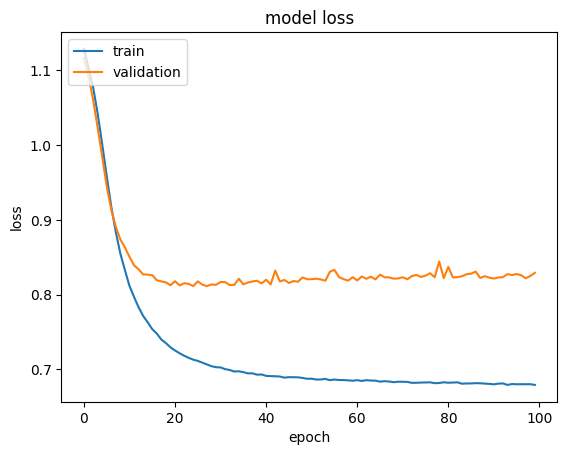

In [23]:
#plot the training loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

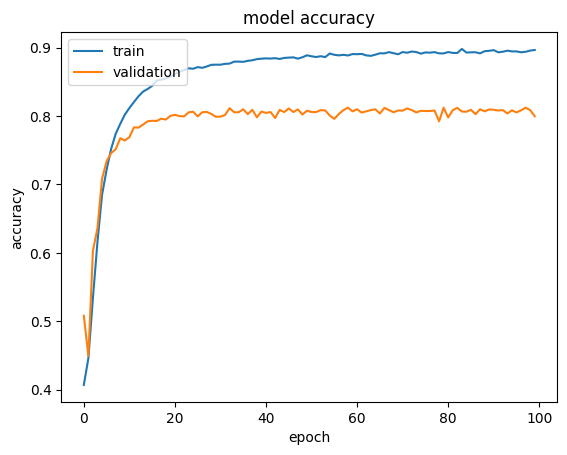

In [24]:
#plot the training loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [27]:
history.history['val_f1_score']

[array([0.6413431 , 0.01404741, 0.46991703], dtype=float32),
 array([0.59486204, 0.05163511, 0.23462899], dtype=float32),
 array([0.6773977 , 0.43495664, 0.5591398 ], dtype=float32),
 array([0.69997656, 0.47563356, 0.6246305 ], dtype=float32),
 array([0.7433814 , 0.6766917 , 0.67359054], dtype=float32),
 array([0.7642818, 0.6832298, 0.7288579], dtype=float32),
 array([0.77377605, 0.7045685 , 0.7383016 ], dtype=float32),
 array([0.7783634 , 0.7107692 , 0.74396133], dtype=float32),
 array([0.78712726, 0.734469  , 0.76766026], dtype=float32),
 array([0.7889138 , 0.71937174, 0.76340425], dtype=float32),
 array([0.7921395 , 0.75024587, 0.74874145], dtype=float32),
 array([0.8008177 , 0.7682811 , 0.77150303], dtype=float32),
 array([0.80196875, 0.76783144, 0.76889473], dtype=float32),
 array([0.8028004, 0.7741936, 0.7769661], dtype=float32),
 array([0.80931324, 0.78842676, 0.7705433 ], dtype=float32),
 array([0.8078115 , 0.77685136, 0.78768986], dtype=float32),
 array([0.8075144, 0.7911571, 

In [33]:
#calculate the best validation accuracy, precision, recall and f1 score
val_accuracy = max(history.history['val_accuracy'])
val_precision = np.mean(history.history['val_precision_3'])
val_recall = max(history.history['val_recall_3'])
val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-9) 

print(f'Validation accuracy: {val_accuracy}')
print(f'Validation precision: {val_precision}')
print(f'Validation recall: {val_recall}')
print(f'Validation f1 score: {val_f1_score}')



Validation accuracy: 0.8123084902763367
Validation precision: 0.8542508161067963
Validation recall: 0.7597037553787231
Validation f1 score: 0.8042079549144123


In [34]:
#save the model and history
model.save('model.h5')
dump(history.history, 'history.joblib')

c:\Users\Benya\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['history.joblib']